In [ ]:
# !pip install torchsummary
# !pip install torchvision

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from torch import nn
import torch, torchvision, os
from torchsummary import summary
import numpy as np

In [ ]:
def tensor_to_numpy(source, output_file):
    list_ = ['data_test','data_train','label_test','label_train']
    file_save = os.path_join(source, output_file)
    with open(file_save, 'wb') as f:
        for name in list_:
            tensor = torch.load(os.path.join(source, name+'.pt'))
            if len(tensor.shape) == 3:
                tensor = tensor.reshape((tensor.shape[0],1,40,tensor.shape[-1]))
            array = tensor.numpy()
            np.save(f, array)
    return file_save

In [ ]:
file = tensor_to_numpy('', 'features_labels_balanced.npy')

In [ ]:
def load_data(file):
    with open(file, 'rb') as f:
        X_test = np.load(f)
        X_train = np.load(f)
        Y_test = np.load(f)
        Y_train = np.load(f)
    return X_test, X_train, Y_test, Y_train

In [ ]:
X_test, X_train, Y_test, Y_train = load_data(file)

print(f'X_train:{X_train.shape}, y_train:{Y_train.shape}')
print(f'X_test:{X_test.shape}, y_test:{Y_test.shape}')

X_train:(6023, 1, 40, 500), y_train:(6023, 3)
X_test:(1506, 1, 40, 500), y_test:(1506, 3)


## Model

In [ ]:
# Model flow
class define_model(nn.Module):

    # Define layers
    def __init__(self, num_emotions):
        super().__init__()

        transformer_layer = nn.TransformerEncoderLayer(
            d_model=40, #####################
            nhead=4,
            dim_feedforward=512,
            dropout=0.4,
            activation='relu'
        )
        self.transformer_maxpool = nn.MaxPool2d(kernel_size=[1,4], stride=[1,4])
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=4)

        #maxpool: reshape (width, height)
        #conv: reshape (channel)
        conv2d_layer = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(16),#######
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.3),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(32),#######
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(64),#######
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
        )
        self.conv2Dblock1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(16),#######
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.3),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(32),#######
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(64),#######
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
        )
        self.conv2Dblock2 = conv2d_layer

        self.fc1_layer = nn.Linear(960*2+40, 980)
        self.act1 = nn.ReLU()
        self.fc2_layer = nn.Linear(980, num_emotions)
        self.softmax_out = nn.Softmax(dim=1)

    def forward(self, x):
        conv2d_embedding1 = self.conv2Dblock1(x)
        conv2d_embedding1 = torch.flatten(conv2d_embedding1, start_dim = 1)

        conv2d_embedding2 = self.conv2Dblock2(x)
        conv2d_embedding2 = torch.flatten(conv2d_embedding2, start_dim = 1)

        x_maxpool = self.transformer_maxpool(x)
        x_maxpool_reduced = torch.squeeze(x_maxpool,1) ############
        x = x_maxpool_reduced.permute(2,0,1) ###########
        transformer_output = self.transformer_encoder(x)
        transformer_embedding = torch.mean(transformer_output, dim = 0)

        complete_embedding = torch.cat([conv2d_embedding1, conv2d_embedding2, transformer_embedding], dim = 1)
        fc1 = self.fc1_layer(complete_embedding)
        ac1 = self.act1(fc1)
        output_logits = self.fc2_layer(ac1)
        output_softmax = self.softmax_out(output_logits)
        return output_logits, output_softmax

In [ ]:
# Training step
def make_train_step(model, criterion, optimizer):
    def train_step(X, Y):
        output_logits, output_softmax = model(X)
        predictions = torch.argmax(output_softmax, dim=1)
        Y = torch.argmax(Y, dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))
        loss = criterion(output_logits, Y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss.item(), accuracy*100
    return train_step

#validation step
def make_validate_fnc(model, criterion):
    def validate(X,Y):
        with torch.no_grad():
            model.eval()
            output_logits, output_softmax = model(X)
            predictions = torch.argmax(output_softmax, dim=1)
            Y = torch.argmax(Y, dim=1)
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            loss = criterion(output_logits, Y)
        return loss.item(), accuracy*100, predictions
    return validate

In [ ]:
def make_save_checkpoint():
    def save_checkpoint(optimizer, model, epoch, filename):
        checkpoint_dict = {
            'optimizer': optimizer.state_dict(),
            'model': model.state_dict(),
            'epoch': epoch
        }
        torch.save(checkpoint_dict, filename)
    return save_checkpoint

def load_checkpoint(optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    epoch = checkpoint_dict['epoch']
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    return epoch

## Training loop

In [ ]:
emotions_dict ={
    '0':'positive',
    '1':'neutral',
    '2':'negative'}

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'{device} selected')

model = define_model(len(emotions_dict)).to(device)
print('Number of trainable params: ', sum(p.numel() for p in model.parameters()))
# Define optimizer
def choose_optimizer(kind, learning_rate, w_decay, model):
  if kind == 'SGD':
    return torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=w_decay, momentum=0.3)
  if kind == 'ADAM':
    return torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=w_decay, eps = 1e-08)
# Define loss/ criterion
def criterion(predictions, targets):
    return nn.CrossEntropyLoss()(input=predictions, target=targets)

optimizer = choose_optimizer('SGD',0.1,1e-3, model)
save_checkpoint = make_save_checkpoint()
train_step = make_train_step(model, criterion, optimizer)
validate = make_validate_fnc(model, criterion)

train_losses = []
valid_losses = []

cuda selected


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Number of trainable params:  2164691


In [ ]:
def train(optimizer, model, num_epochs, X_train, Y_train, X_valid, Y_valid, list_acc, list_loss):
    train_size = X_train.shape[0]
    minibatch = 128
    acc_max = 0
    for epoch in range(num_epochs):
        #set to train phase
        model.train()

        train_indices = np.random.permutation(train_size)
        X_train = X_train[train_indices,:,:,:]
        Y_train = Y_train[train_indices,:]

        epoch_acc = 0
        epoch_loss = 0
        num_iterations = int(train_size/minibatch)

        for i in range(num_iterations):
            batch_start = i*minibatch
            batch_end = min(batch_start + minibatch, train_size)
            actual_batch_size = batch_end - batch_start

            X = X_train[batch_start:batch_end,:,:,:]
            Y = Y_train[batch_start:batch_end,:]

            X_tensor = torch.tensor(X, device = device).float()
            Y_tensor = torch.tensor(Y, dtype = torch.long, device = device)

            loss, acc = train_step(X_tensor, Y_tensor)

            epoch_acc += acc * actual_batch_size / train_size
            epoch_loss += loss * actual_batch_size / train_size

        X_valid_tensor = torch.tensor(X_test, device = device).float()
        Y_valid_tensor = torch.tensor(Y_test, dtype = torch.long, device = device)
        valid_loss, valid_acc, _ = validate(X_valid_tensor,Y_valid_tensor)
        list_acc[0].append(epoch_acc.cpu().numpy())
        list_acc[1].append(valid_acc.cpu().numpy())
        list_loss[0].append(epoch_loss)
        list_loss[1].append(valid_loss)

        if acc_max > int(epoch_acc):
          continue
        acc_max = epoch_acc
        # checkpoint_filename = 'cnn_transformerFINAL-{:03d}.pkl'.format(epoch)
        # save_checkpoint(optimizer, model, epoch, checkpoint_filename)
        torch.save(model.state_dict(),'model'+str(epoch)+'.pt')

        print(f'\nEpoch {epoch} --- loss:{epoch_loss:.3f}, Epoch accuracy:{epoch_acc:.2f}%, Validation loss:{valid_loss:.3f}, Validation accuracy:{valid_acc:.3f}')

In [ ]:
num_epochs = 200
list_acc = [[],[]]
list_loss = [[],[]]
train(optimizer, model, num_epochs, X_train, Y_train, X_test, Y_test, list_acc, list_loss)

Text(0.5, 1.0, 'SGD lr:0.1 weight_decay:1e-3')

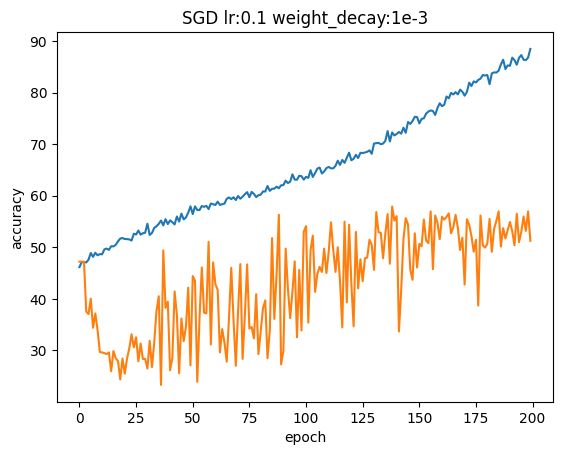

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(num_epochs),list_acc[0])
plt.plot(range(num_epochs),list_acc[1])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('SGD lr:0.1 weight_decay:1e-3')